# Import Libraries

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.preprocessing import MinMaxScaler

sns.set()

# Preprocess data

In [2]:
data = pd.read_csv('/kaggle/input/global-weather-repository/GlobalWeatherRepository.csv')
data.head()

,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,...,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination
0,Afghanistan,Kabul,34.52,69.18,Asia/Kabul,1715849100,2024-05-16 13:15,26.6,79.8,Partly Cloudy,...,8.4,26.6,1,1,04:50 AM,06:50 PM,12:12 PM,01:11 AM,Waxing Gibbous,55
1,Albania,Tirana,41.33,19.82,Europe/Tirane,1715849100,2024-05-16 10:45,19.0,66.2,Partly cloudy,...,1.1,2.0,1,1,05:21 AM,07:54 PM,12:58 PM,02:14 AM,Waxing Gibbous,55
2,Algeria,Algiers,36.76,3.05,Africa/Algiers,1715849100,2024-05-16 09:45,23.0,73.4,Sunny,...,10.4,18.4,1,1,05:40 AM,07:50 PM,01:15 PM,02:14 AM,Waxing Gibbous,55
3,Andorra,Andorra La Vella,42.50,1.52,Europe/Andorra,1715849100,2024-05-16 10:45,6.3,43.3,Light drizzle,...,0.7,0.9,1,1,06:31 AM,09:11 PM,02:12 PM,03:31 AM,Waxing Gibbous,55
4,Angola,Luanda,-8.84,13.23,Africa/Luanda,1715849100,2024-05-16 09:45,26.0,78.8,Partly cloudy,...,183.4,262.3,5,10,06:12 AM,05:55 PM,01:17 PM,12:38 AM,Waxing Gibbous,55


In [3]:
data['latitude'].nunique()

383

In [4]:
data['last_updated'] = pd.to_datetime(data['last_updated'])

# Building an LSTM model

In the EDA, we discussed that the temperatures have a time trend but trend they follow depends on the latitude of the place. We have trained an ensemble model -- the XGBoost model to predict the temperature based on the humidity, pressure, uv index, and the latitude values. But, it is important to note that when we try to predict the future forecast, we will probably not have access to the features like humidity, pressure, and uv index. We will however, know the latitude for the region we need to predict the temperature and the time at which we want the prediction. We thus want to train a model that is able to learn a time series trend or a function that models the temperature that depends on the latitude of the region.

An LSTM would be a good choice for this. This is because the LSTM model is great at time series prediction. Intuitively, the LSTM model will learn parameters that can model the time series trend based on the latitude of the region. 

## Creating the data

We will first put together the data. The data will have the sequences with the features we want.

In [5]:
def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    
    data = data.sort_values(by=["latitude", "last_updated"])
    
    unique_latitudes = data["latitude"].unique()
    
    for lat in unique_latitudes:
        lat_data = data[data["latitude"] == lat]
        temperatures = lat_data["temperature_celsius"].values
        latitude = lat_data["latitude"].values
        time_steps = len(temperatures)
        
        for i in range(time_steps - sequence_length):
            sequence = np.column_stack((temperatures[i:i + sequence_length], latitude[i:i + sequence_length]))
            sequences.append(sequence)
            
            targets.append(temperatures[i + sequence_length])
    
    return np.array(sequences), np.array(targets)

In [6]:
sequence_length = 10
X, y = create_sequences(data, sequence_length)

In [7]:
print("Input shape:", X.shape)
print("Target shape:", y.shape)

Input shape: (43593, 10, 2)
Target shape: (43593,)


## Building the LSTM model

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Training set: (30515, 10, 2), (30515,)
Validation set: (6539, 10, 2), (6539,)
Test set: (6539, 10, 2), (6539,)


In [9]:
scaler = MinMaxScaler()

X_flat = X.reshape(-1, X.shape[-1])
X_scaled = scaler.fit_transform(X_flat)

X = X_scaled.reshape(X.shape)

y = scaler.fit_transform(y.reshape(-1, 1)).flatten()

In [10]:
def create_lstm_model(sequence_length, num_features):
    model = Sequential([
        Input(shape=(sequence_length, num_features)),
        LSTM(64, return_sequences=False),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [11]:
sequence_length = X_train.shape[1]
num_features = X_train.shape[2]

model = create_lstm_model(sequence_length, num_features)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=50,
    verbose=1
)

Epoch 1/50
954/954 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 153.6070 - mae: 7.9256 - val_loss: 6.4920 - val_mae: 1.8193
Epoch 2/50
954/954 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 9.5223 - mae: 2.3486 - val_loss: 5.9484 - val_mae: 1.7404
Epoch 3/50
954/954 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 8.7187 - mae: 2.2396 - val_loss: 5.7066 - val_mae: 1.7035
Epoch 4/50
954/954 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 8.6204 - mae: 2.2282 - val_loss: 5.6795 - val_mae: 1.6989
Epoch 5/50
954/954 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 8.2911 - mae: 2.1763 - val_loss: 5.7081 - val_mae: 1.6902
Epoch 6/50
954/954 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 7.9779 - mae: 2.1348 - val_loss: 5.6631 - val_mae: 1.6846
Epoch 7/50
954/954 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 7.8951 - mae: 2.1117 - val_loss: 5.8350 - val_mae: 1.7625
Epoch 8/50
954/954 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 7.5781 - mae: 2.0730 - val_loss: 5.7955 - val_mae: 1.7116
Epoch 9/50
954/954 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - 

In [12]:
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.8367 - mae: 1.7379
Test Loss: 5.6457695960998535, Test MAE: 1.7177670001983643


In [13]:
predicted_temp = model.predict(X_test)

205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


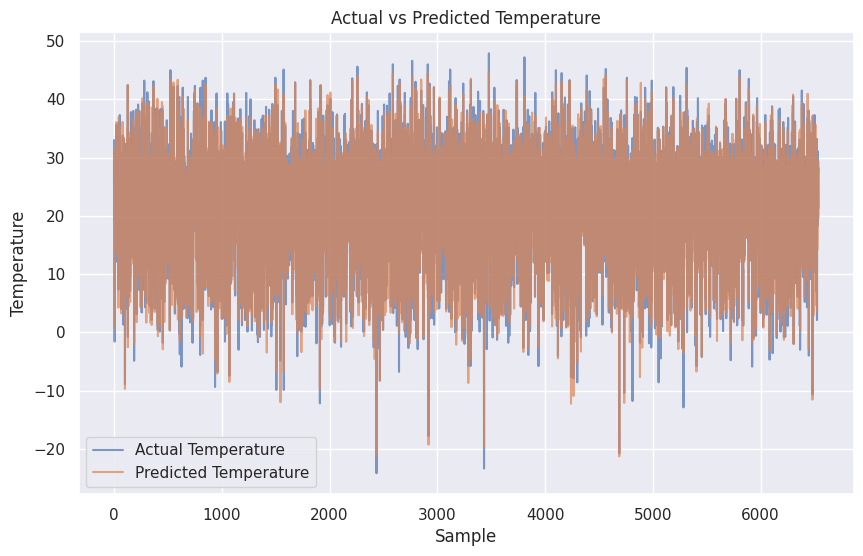

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label="Actual Temperature", alpha=0.7)
plt.plot(predicted_temp, label="Predicted Temperature", alpha=0.7)
plt.title("Actual vs Predicted Temperature")
plt.xlabel("Sample")
plt.ylabel("Temperature")
plt.legend()
plt.show()

In [15]:
mae = mean_absolute_error(y_test, predicted_temp)
mse = mean_squared_error(y_test, predicted_temp)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predicted_temp)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")

Mean Absolute Error (MAE): 1.7177665824207589
Mean Squared Error (MSE): 5.64576993804394
Root Mean Squared Error (RMSE): 2.3760828979738773
R² Score: 0.9305216980406187


The LSTM model does pretty well as the R-squared value is very close to 1. The R-squared value measures the amount of variance in the temperature data explained by the model. Since the R-squared value is so high, we can see that we have a reasonable model. abs